In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Загрузка DataFrame из файла
with open(r'./datasets/dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
crystal = df['Crystal']
Crystal = []

for i in crystal:
    i = i[1:]
    foo, fooo = i.split(".")
    i = foo
    #print(i)
    Crystal.append(i)

In [6]:
df['Crystal'] = Crystal
df = df.loc[((df['Crystal'] != 'Ag') & (df['Crystal'] != 'Au') & (df['Crystal'] != 'B4C'))]
df = df.reset_index()
df

index                                             Matrix Crystal  \
0       120  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   
1       121  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   
2       122  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   
3       123  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   
4       124  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      Al   
...     ...                                                ...     ...   
4195   4555  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3   
4196   4556  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3   
4197   4557  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3   
4198   4558  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3   
4199   4559  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    Y2O3   

            Stats  Pulce duration  
0      10000000.0       10.000000  
1      10000000.0       25.263158  
2      10000000.0       40.526316  
3      10000000.0       55.789474  
4      10000000.0       71.052632  
...           ...             ...  
4195  500000000.0      238.947368  
4196  500000000.0      254.210526  
4197  500000000.0      269.473684  
4198  500000000.0      284.736842  
4199  500000000.0      300.000000  

[4200 rows x 5 columns]

In [ ]:
df['Crystal'].unique()

array(['Al', 'Al2O3_sapphire', 'Ba', 'Be', 'BeO', 'C_diamond',
       'C_graphite', 'Cr', 'Cs', 'Cu', 'Cu2MnAl', 'Fe', 'Ga', 'Gd', 'Ge',
       'H2O_ice_1h', 'He4_hcp', 'Hg', 'I2', 'K', 'Li', 'LiF', 'Mo',
       'Na2Ca3Al2F14', 'Nb', 'Ni', 'Pb', 'Pt', 'Rb', 'Si', 'Ti', 'Tl',
       'UO2', 'Zn', 'Y2O3'], dtype=object)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Преобразуем список матриц в 3D массив (количество матриц, высота, ширина)
matrices = np.array(df['Matrix'].tolist())

# Вычисляем среднее и стандартное отклонение для каждого пикселя по всем матрицам
X_mean = matrices.mean(axis=0, keepdims=True)
X_std = matrices.std(axis=0, keepdims=True)

# Избегаем деления на ноль
X_std[X_std == 0] = 1

# Нормализуем все матрицы
matrices_normalized = (matrices - X_mean) / X_std

# Возвращаем нормализованные матрицы обратно в DataFrame
df['Matrix'] = list(matrices_normalized)

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

Подгрузка датасетов для обучения на масках сегментации

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)

# Шаг 1: Преобразование строковых меток классов в числовые метки
label_encoder = LabelEncoder()

y = df['Crystal']

y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, random_state=42)

In [9]:
len(df['Crystal'].unique())

35

In [10]:
# Преобразование матриц в numpy массив перед преобразованием в тензоры
X_train_matrices = np.array(X_train['Matrix'].tolist())
X_test_matrices = np.array(X_test['Matrix'].tolist())

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train_matrices)
y_train_tensor = torch.LongTensor(y_train)  # Используем LongTensor для целевых меток

X_test_tensor = torch.FloatTensor(X_test_matrices)
y_test_tensor = torch.LongTensor(y_test)

In [11]:
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
X_train_tensor.size()

torch.Size([3780, 1, 250, 480])

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Загружаем предобученную ResNet18
model = models.resnet18(pretrained=True)

# Изменяем первый сверточный слой
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Инициализируем веса первого слоя
nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

# Изменяем последний полносвязный слой для вашего количества классов
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 35)

c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\neUral\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
for name, param in model.named_parameters():
    if "layer1" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [13]:
for name, param in model.named_parameters():
    if "layer1" in name or "layer2" in name or "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Пример модели U-Net
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.decoder1 = self.up_conv(512, 256)
        self.decoder2 = self.up_conv(256, 128)
        self.decoder3 = self.up_conv(128, 64)
        self.decoder4 = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, 2))
        e3 = self.encoder3(F.max_pool2d(e2, 2))
        e4 = self.encoder4(F.max_pool2d(e3, 2))

        # Decoder
        d1 = self.decoder1(F.interpolate(e4, scale_factor=1, mode='bilinear', align_corners=True))
        d2 = self.decoder2(F.interpolate(d1 + e3, scale_factor=1, mode='bilinear', align_corners=True))
        d2 = F.pad(d2, (0, 0, 1, 0))  # (left, right, top, bottom)
        d3 = self.decoder3(F.interpolate(d2 + e2, scale_factor=1, mode='bilinear', align_corners=True))
        d4 = self.decoder4(F.interpolate(d3 + e1, scale_factor=1, mode='bilinear', align_corners=True))

        return torch.sigmoid(d4)  # Применяем softmax для многоклассовой классификации

In [15]:
get_seg_mask = UNet().to(device)
get_seg_mask.load_state_dict(torch.load(r'model_weights_withoutBeam_unique.pth'))

<All keys matched successfully>

In [16]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Создание набора данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Создание DataLoader для каждой выборки
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [17]:
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))

In [18]:
epochs = 10
history = []
history_test = []
num_bach = 0
baches = []

In [19]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

Epoch 1, Loss: (0.08668356388807297, 2), Loss test: (0.060905106365680695, 2)


KeyboardInterrupt: 

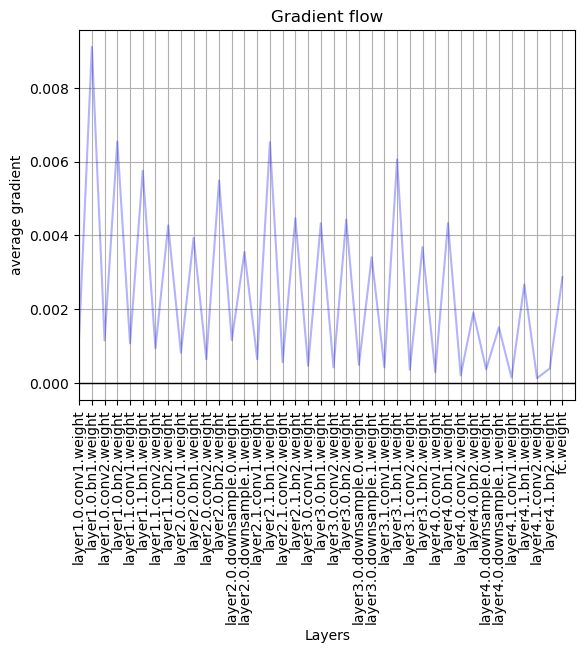

In [20]:
for i in range(epochs):
  
  model.train()  # Включаем режим обучения

  for x_batch, y_batch in train_loader:
    num_bach+=1
    # 1. # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    mask = get_seg_mask(x_batch)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
    logits = model(mask)
    #logits = model(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = criterion(logits, y_batch)
    
    history.append(loss.item())

    # 4. вычисляем градиенты
    optimizer.zero_grad()
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

  with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        maps = get_seg_mask(inputs)

        outputs = model(maps)  # Получаем логиты от модели
        #outputs = model(inputs)

        test_loss = criterion(outputs, targets)
        history_test.append(test_loss.item())
        baches.append(num_bach)

  plot_grad_flow(model.named_parameters())
  print(f'Epoch {i+1}, Loss: {history[-1], 2}, Loss test: {history_test[-1], 2}')

Обучение только классификатора, с замороженными свертками

In [34]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

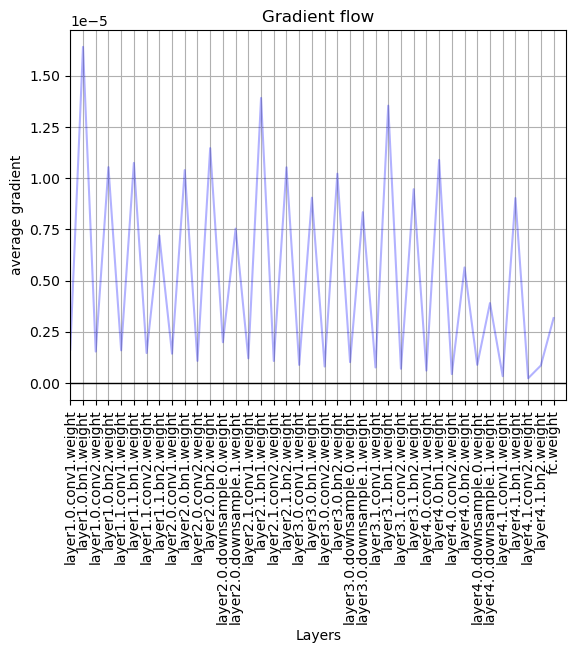

In [49]:
plot_grad_flow(model.named_parameters())

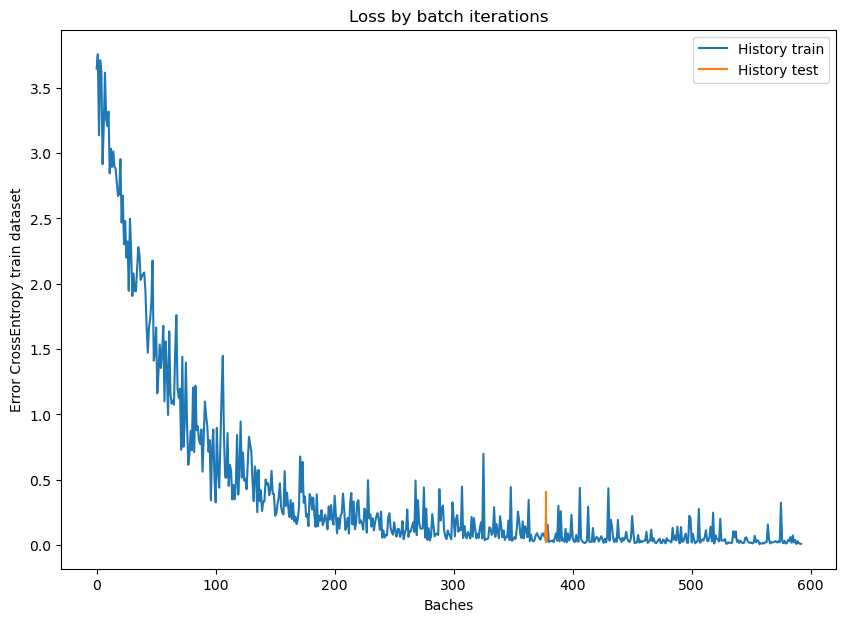

In [21]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(baches, history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Error CrossEntropy train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

Обучения с разморозкой сверток

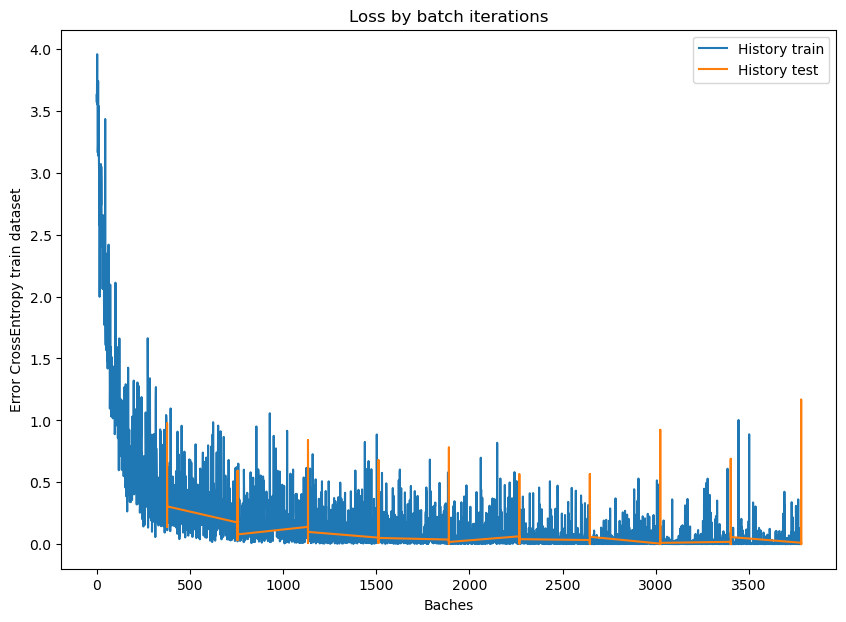

In [79]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(baches, history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Error CrossEntropy train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [80]:
num_classes = 35

cristals = ["\"Al.laz\"", "\"Al2O3_sapphire.laz\"", "\"Ba.laz\"", "\"Be.laz\"", "\"BeO.laz\"", "\"C_diamond.laz\"", "\"C_graphite.laz\"", "\"Cr.laz\"", "\"Cs.laz\"", "\"Cu.laz\"", "\"Cu2MnAl.laz\"", "\"Fe.laz\"", "\"Ga.laz\"", "\"Gd.laz\"", "\"Ge.laz\"", "\"H2O_ice_1h.laz\"", "\"He4_hcp.laz\"", "\"Hg.laz\"", "\"I2.laz\"", "\"K.laz\"", "\"Li.laz\"", "\"LiF.laz\"", "\"Mo.laz\"", "\"Na2Ca3Al2F14.laz\"", "\"Nb.laz\"", "\"Ni.laz\"", "\"Pb.laz\"", "\"Pt.laz\"", "\"Rb.laz\"", "\"Si.laz\"", "\"Ti.laz\"", "\"Tl.laz\"", "\"UO2.laz\"", "\"Zn.laz\"", "\"Y2O3.laz\""]


# Инициализируем счетчики для правильных предсказаний и общего количества предсказаний для каждого класса
correct_predictions = torch.zeros(num_classes)
total_predictions = torch.zeros(num_classes)

# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        maps = get_seg_mask(inputs)
        outputs = model(maps)  # Получаем логиты от модели
        #outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы

        # Обновляем счетчики для каждого класса
        for i in range(num_classes):
            class_mask = (targets == i)  # Маска для всех примеров класса i
            correct_predictions[i] += (predicted[class_mask] == targets[class_mask]).sum().item()
            total_predictions[i] += class_mask.sum().item()

# Вычисляем отношение верных предсказаний к общему количеству предсказаний для каждого класса
class_accuracies = correct_predictions / total_predictions

# Выводим результаты
for i in range(num_classes):
    print(f'Класс {cristals[i]}: Точность {class_accuracies[i]:.2f} ({correct_predictions[i]}/{total_predictions[i]})')


Класс "Al.laz": Точность 1.00 (14.0/14.0)
Класс "Al2O3_sapphire.laz": Точность 1.00 (19.0/19.0)
Класс "Ba.laz": Точность 1.00 (12.0/12.0)
Класс "Be.laz": Точность 1.00 (9.0/9.0)
Класс "BeO.laz": Точность 1.00 (16.0/16.0)
Класс "C_diamond.laz": Точность 1.00 (9.0/9.0)
Класс "C_graphite.laz": Точность 1.00 (16.0/16.0)
Класс "Cr.laz": Точность 1.00 (11.0/11.0)
Класс "Cs.laz": Точность 1.00 (16.0/16.0)
Класс "Cu.laz": Точность 1.00 (11.0/11.0)
Класс "Cu2MnAl.laz": Точность 1.00 (9.0/9.0)
Класс "Fe.laz": Точность 1.00 (16.0/16.0)
Класс "Ga.laz": Точность 1.00 (12.0/12.0)
Класс "Gd.laz": Точность 0.67 (4.0/6.0)
Класс "Ge.laz": Точность 1.00 (12.0/12.0)
Класс "H2O_ice_1h.laz": Точность 1.00 (7.0/7.0)
Класс "He4_hcp.laz": Точность 1.00 (14.0/14.0)
Класс "Hg.laz": Точность 0.50 (7.0/14.0)
Класс "I2.laz": Точность 1.00 (13.0/13.0)
Класс "K.laz": Точность 1.00 (16.0/16.0)
Класс "Li.laz": Точность 0.64 (7.0/11.0)
Класс "LiF.laz": Точность 0.68 (13.0/19.0)
Класс "Mo.laz": Точность 1.00 (13.0/13.0)


In [81]:
# Инициализируем счетчики для каждого класса
num_classes = 35
correct_predictions = torch.zeros(num_classes)  # Количество правильных предсказаний (TP)
total_predictions = torch.zeros(num_classes)  # Общее количество реальных элементов (TP + FN)
false_positives = torch.zeros(num_classes)  # Ложно положительные (FP)
false_negatives = torch.zeros(num_classes)  # Ложно отрицательные (FN)

# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        maps = get_seg_mask(inputs)
        outputs = model(maps)  # Получаем логиты от модели
        #outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы

        # Обновляем счетчики для каждого класса
        for i in range(num_classes):
            class_mask = (targets == i)  # Маска для всех примеров класса i
            predicted_mask = (predicted == i)  # Маска для всех предсказанных как класс i

            # TP: Правильно предсказанные положительные для класса i
            correct_predictions[i] += (predicted[class_mask] == targets[class_mask]).sum().item()
            
            # FN: Примеры класса i, которые не были правильно предсказаны как i
            false_negatives[i] += (predicted[class_mask] != targets[class_mask]).sum().item()
            
            # FP: Примеры, предсказанные как класс i, но которые не являются классом i
            false_positives[i] += (predicted_mask & ~class_mask).sum().item()

            # Общее количество элементов в каждом классе (TP + FN)
            total_predictions[i] += class_mask.sum().item()

# Вычисляем accuracy, precision, recall для каждого класса
class_accuracies = correct_predictions / total_predictions
class_precisions = correct_predictions / (correct_predictions + false_positives)
class_recalls = correct_predictions / (correct_predictions + false_negatives)

# Выводим результаты
for i in range(num_classes):
    print(f'Класс {cristals[i]}:')
    print(f'  Accuracy: {class_accuracies[i]:.2f} ({correct_predictions[i]}/{total_predictions[i]})')
    print(f'  Precision: {class_precisions[i]:.2f}')
    print(f'  Recall: {class_recalls[i]:.2f}')
    print()

Класс "Al.laz":
  Accuracy: 1.00 (14.0/14.0)
  Precision: 1.00
  Recall: 1.00

Класс "Al2O3_sapphire.laz":
  Accuracy: 1.00 (19.0/19.0)
  Precision: 1.00
  Recall: 1.00

Класс "Ba.laz":
  Accuracy: 1.00 (12.0/12.0)
  Precision: 1.00
  Recall: 1.00

Класс "Be.laz":
  Accuracy: 1.00 (9.0/9.0)
  Precision: 1.00
  Recall: 1.00

Класс "BeO.laz":
  Accuracy: 1.00 (16.0/16.0)
  Precision: 1.00
  Recall: 1.00

Класс "C_diamond.laz":
  Accuracy: 1.00 (9.0/9.0)
  Precision: 1.00
  Recall: 1.00

Класс "C_graphite.laz":
  Accuracy: 1.00 (16.0/16.0)
  Precision: 1.00
  Recall: 1.00

Класс "Cr.laz":
  Accuracy: 1.00 (11.0/11.0)
  Precision: 0.92
  Recall: 1.00

Класс "Cs.laz":
  Accuracy: 1.00 (16.0/16.0)
  Precision: 1.00
  Recall: 1.00

Класс "Cu.laz":
  Accuracy: 1.00 (11.0/11.0)
  Precision: 1.00
  Recall: 1.00

Класс "Cu2MnAl.laz":
  Accuracy: 1.00 (9.0/9.0)
  Precision: 1.00
  Recall: 1.00

Класс "Fe.laz":
  Accuracy: 1.00 (16.0/16.0)
  Precision: 1.00
  Recall: 1.00

Класс "Ga.laz":
  Accurac

In [82]:
import torch
import torchmetrics
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

# Количество классов в вашей задаче
num_classes = 35

# Инициализация метрик для каждого класса
accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average=None).to(device)
precision_metric = MulticlassPrecision(num_classes=num_classes, average=None).to(device)
recall_metric = MulticlassRecall(num_classes=num_classes, average=None).to(device)

# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        maps = get_seg_mask(inputs)
        outputs = model(maps)  # Получаем логиты от модели
        #outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы

        # Обновляем метрики на основе предсказаний и целевых значений
        accuracy_metric.update(predicted, targets)
        precision_metric.update(predicted, targets)
        recall_metric.update(predicted, targets)

# Получаем результаты для каждого класса
class_accuracies = accuracy_metric.compute()
class_precisions = precision_metric.compute()
class_recalls = recall_metric.compute()

# Выводим результаты
for i in range(num_classes):
    print(f'Класс {cristals[i]}:')
    print(f'  Accuracy: {class_accuracies[i]:.2f}')
    print(f'  Precision: {class_precisions[i]:.2f}')
    print(f'  Recall: {class_recalls[i]:.2f}')
    print()

Класс "Al.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Al2O3_sapphire.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Ba.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Be.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "BeO.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "C_diamond.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "C_graphite.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Cr.laz":
  Accuracy: 1.00
  Precision: 0.92
  Recall: 1.00

Класс "Cs.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Cu.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Cu2MnAl.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Fe.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Ga.laz":
  Accuracy: 1.00
  Precision: 1.00
  Recall: 1.00

Класс "Gd.laz":
  Accuracy: 0.67
  Precision: 0.80
  Recall: 0.67

Класс "Ge.laz":
  Accuracy: 1

Accuracy: 0.77
Precision (Weighted): 0.80
Recall (Weighted): 0.77
F1-Score (Weighted): 0.78


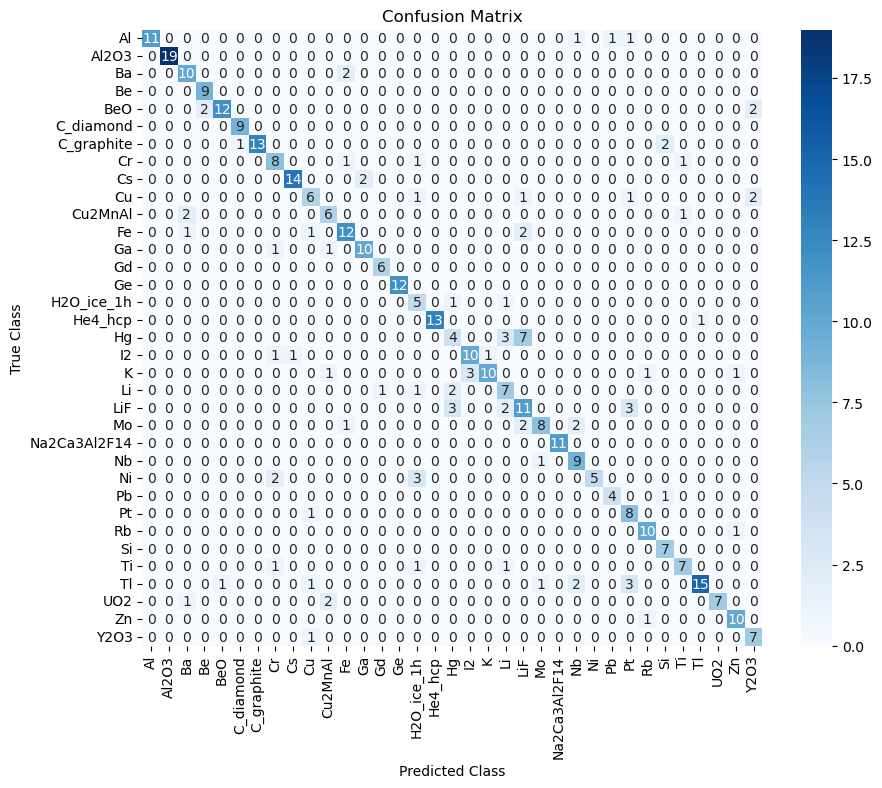

In [21]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Определим количество классов
num_classes = 35  # Замените на ваше количество классов
cristals = ["Al", "Al2O3", "Ba", "Be", "BeO", "C_diamond", "C_graphite", "Cr", "Cs", "Cu", "Cu2MnAl", "Fe", "Ga", "Gd", "Ge", "H2O_ice_1h", "He4_hcp", "Hg", "I2", "K", "Li", "LiF", "Mo", "Na2Ca3Al2F14", "Nb", "Ni", "Pb", "Pt", "Rb", "Si", "Ti", "Tl", "UO2", "Zn", "Y2O3"]


# Списки для хранения предсказаний и истинных значений
all_preds = []
all_targets = []

# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        maps = get_seg_mask(inputs)
        outputs = model(maps)
        #outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Добавляем предсказания и целевые значения в списки
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Преобразуем списки в numpy-массивы
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Вычисляем метрики на всем датасете
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Построение и визуализация матрицы ошибок
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=cristals, yticklabels=cristals)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [51]:
diffs = []
outs = []
# Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
with torch.no_grad():
    for inputs, targets in test_loader:
        for diff, target in zip(inputs, targets):
            if target == 21:
                diff = diff.to(device)
                diff = diff.unsqueeze(1)
                #print(diff.size())
                maps = get_seg_mask(diff)

                diffs.append(diff.cpu().numpy())
                outs.append(maps.cpu().numpy())

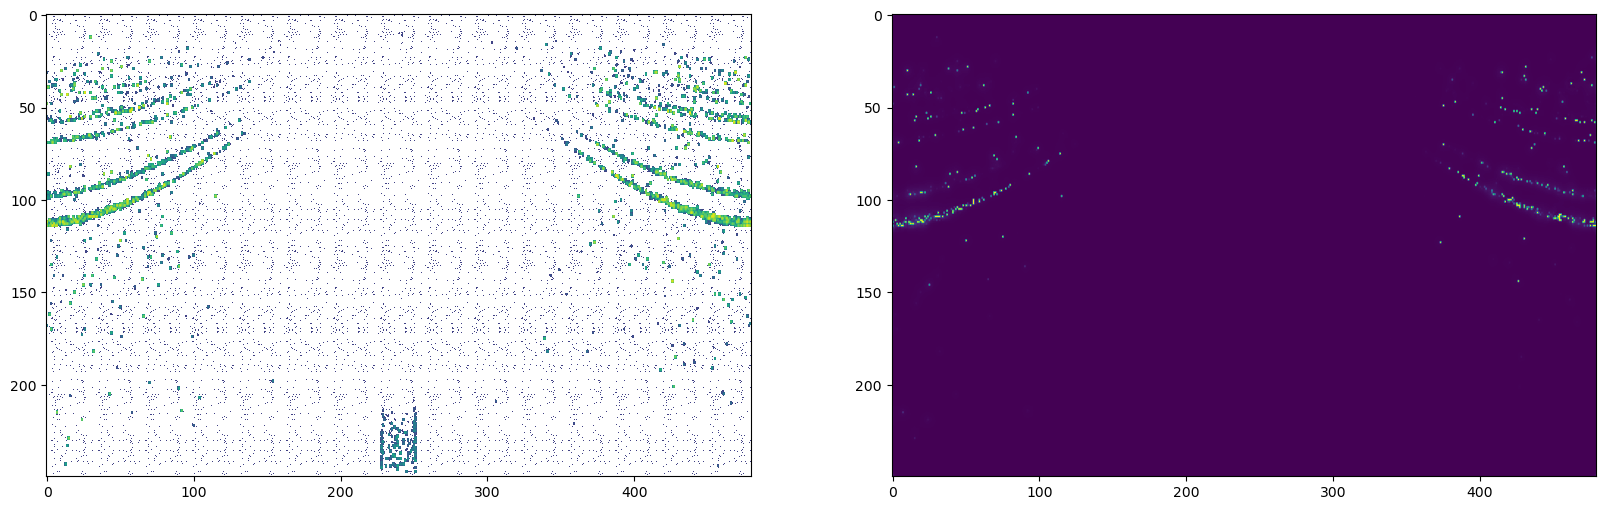

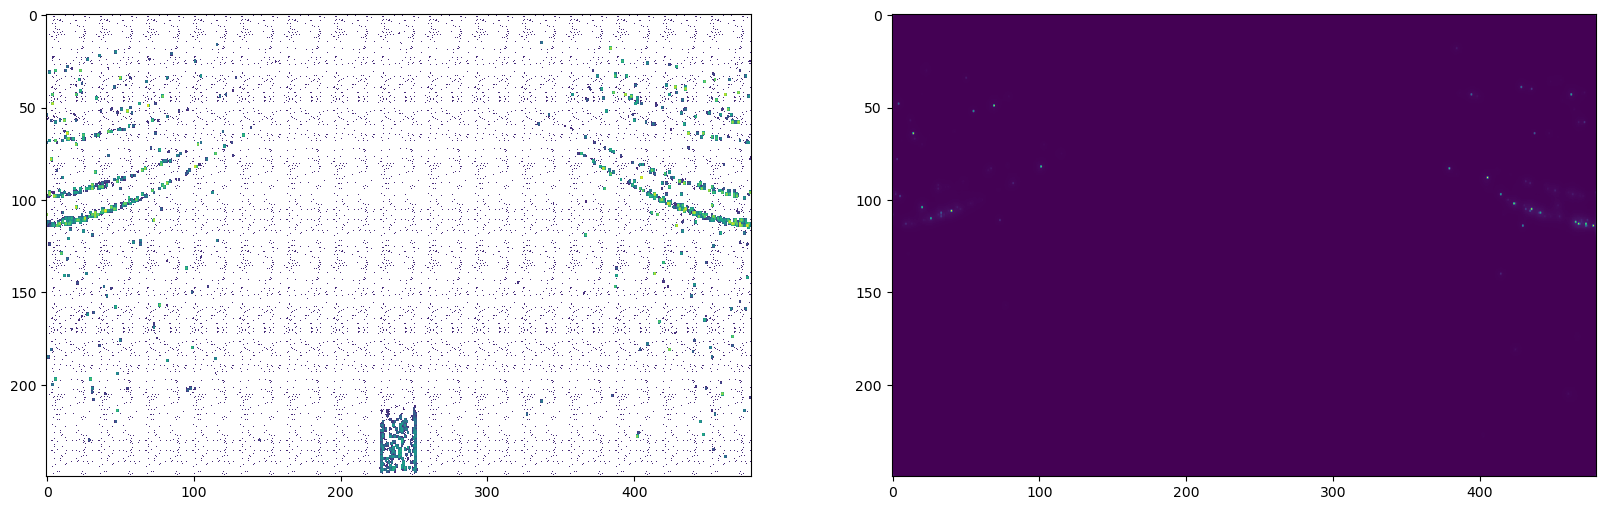

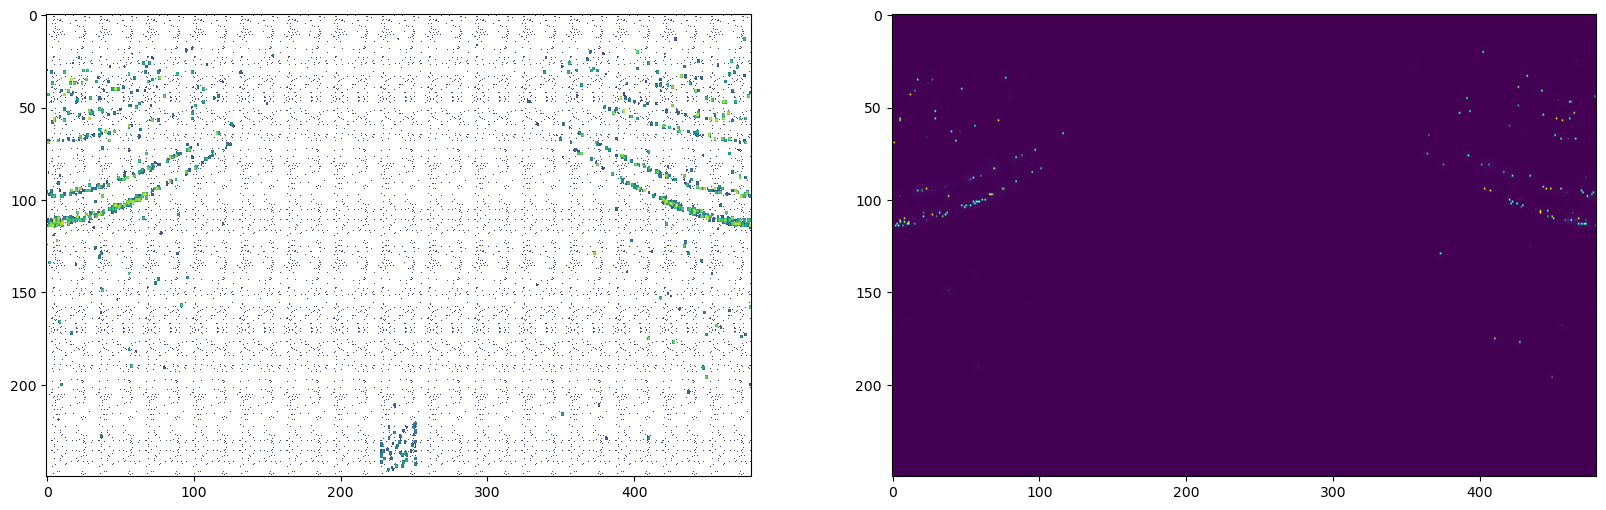

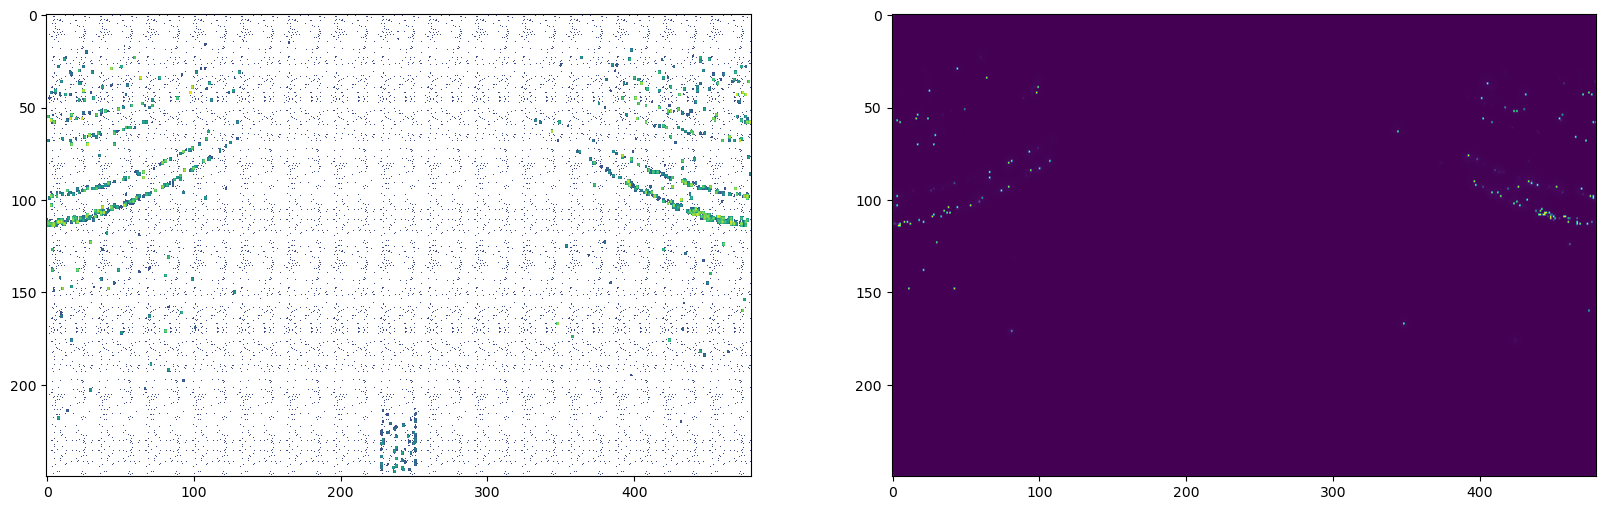

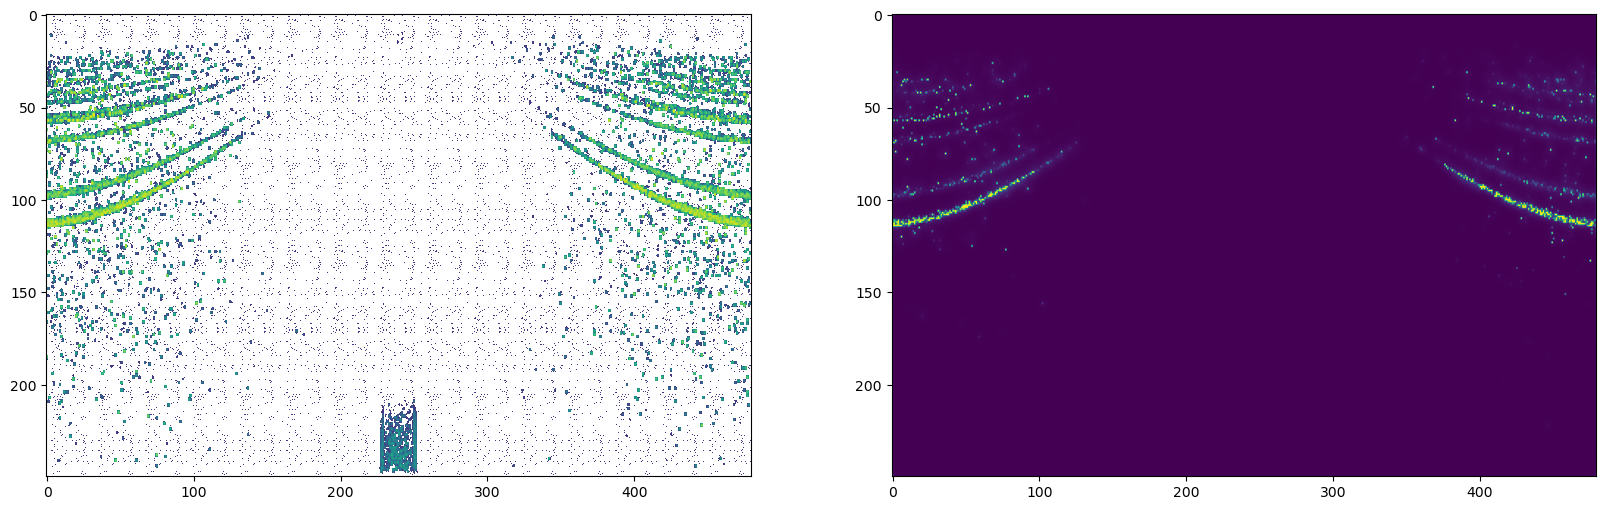

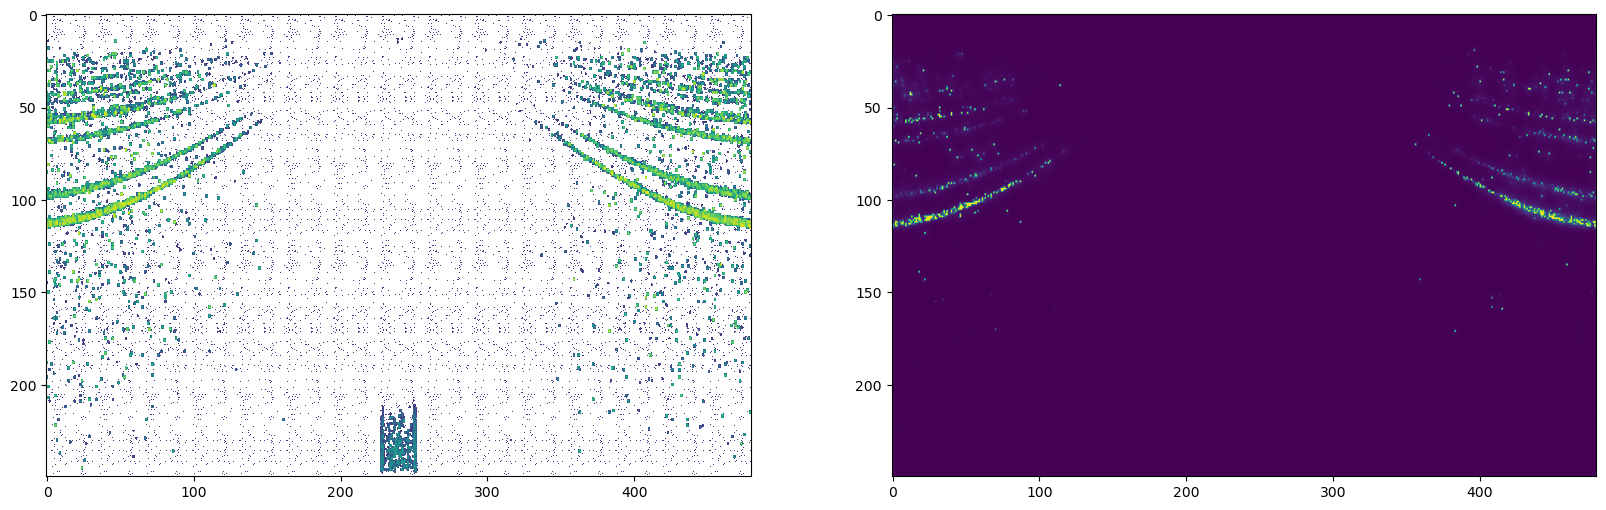

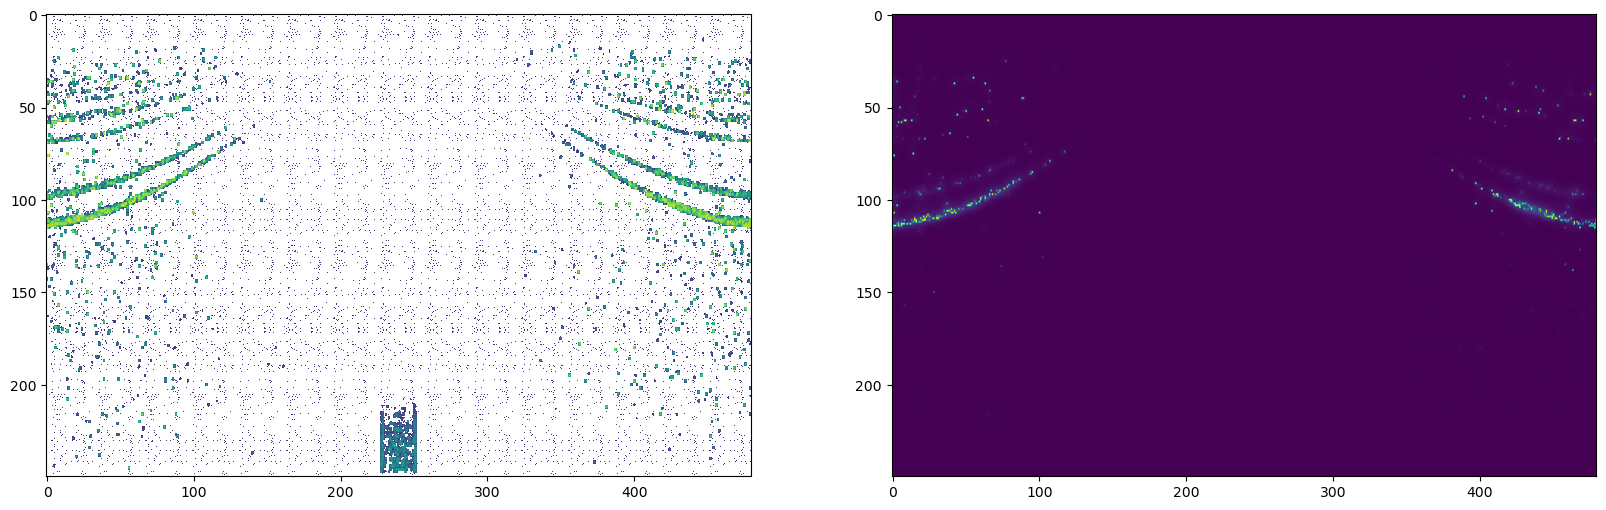

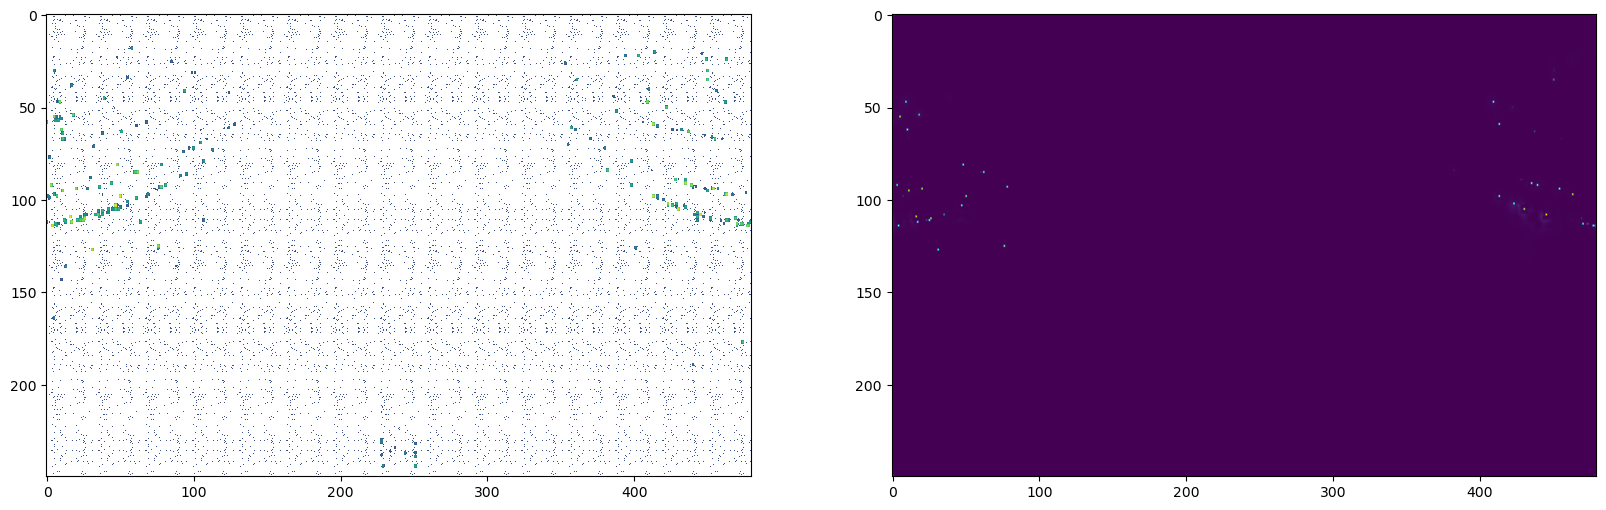

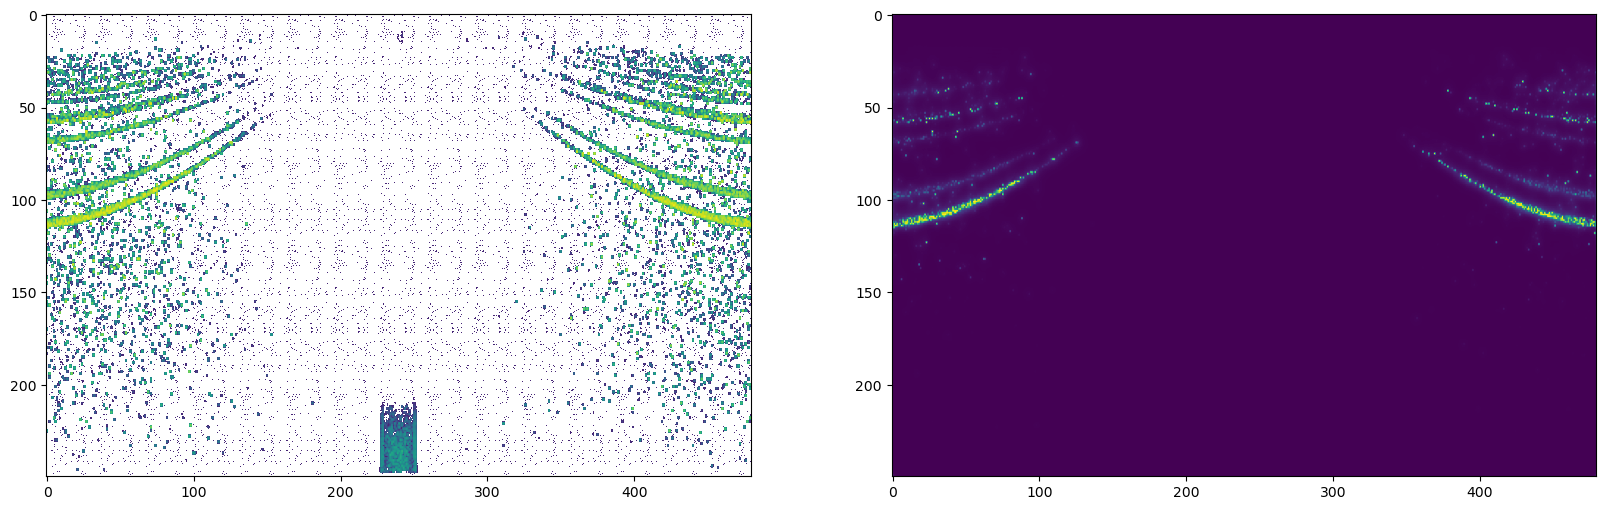

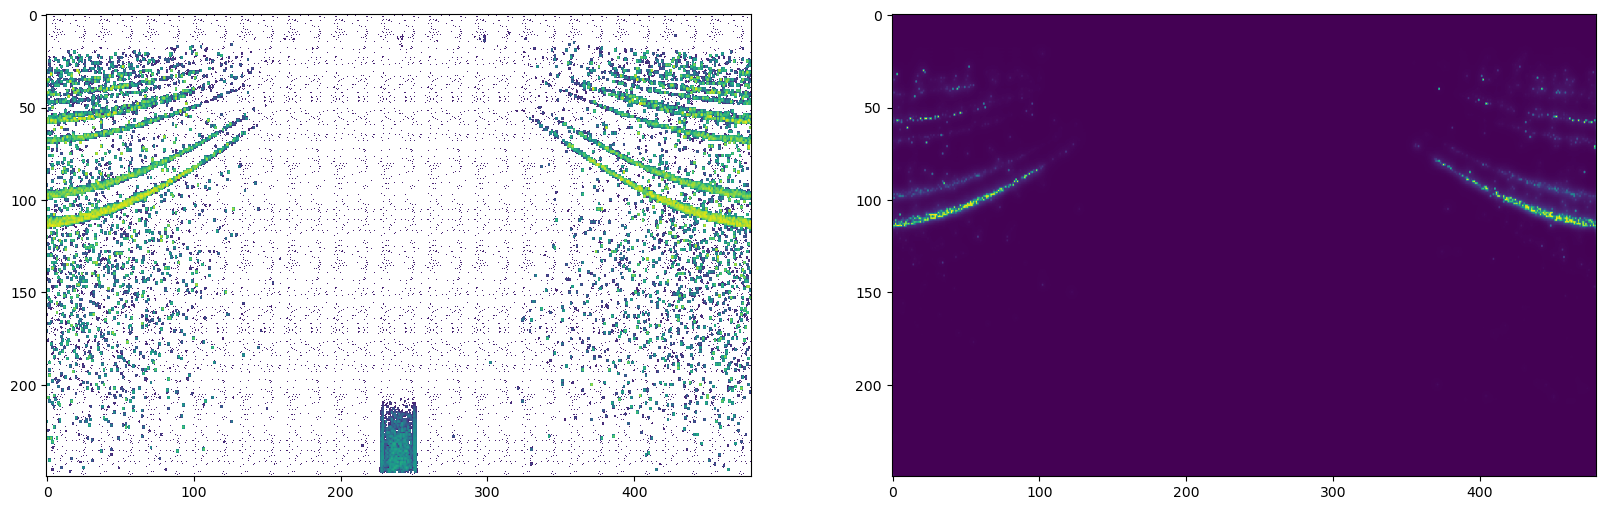

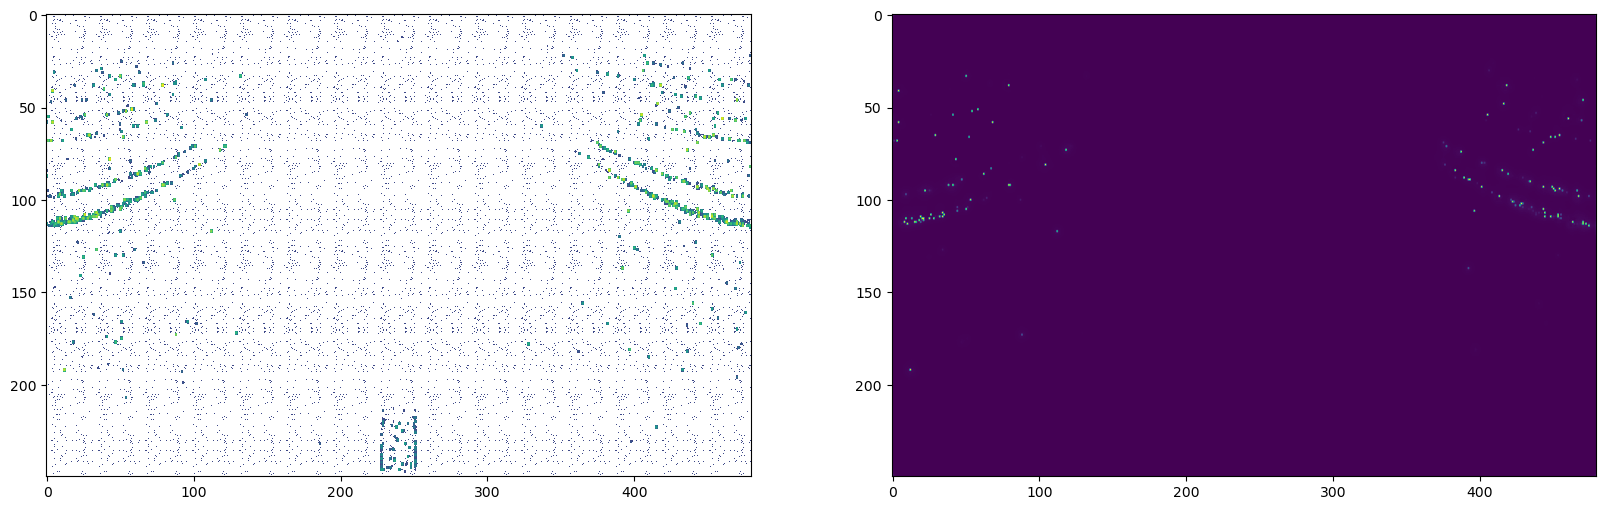

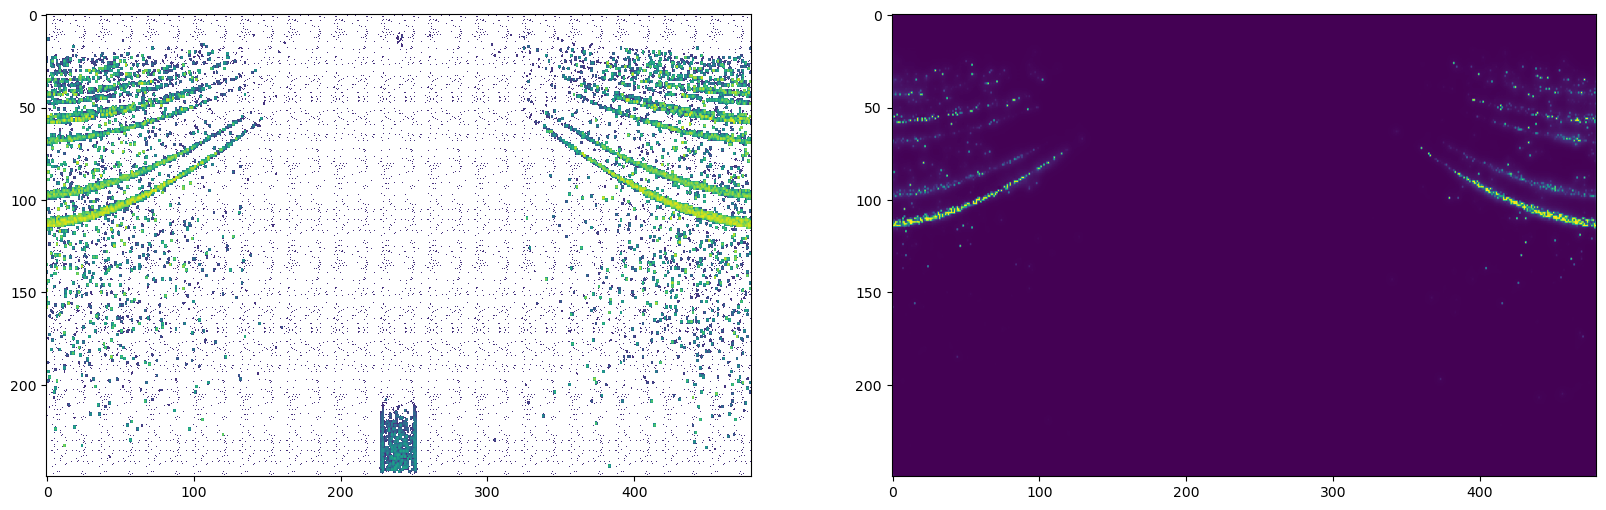

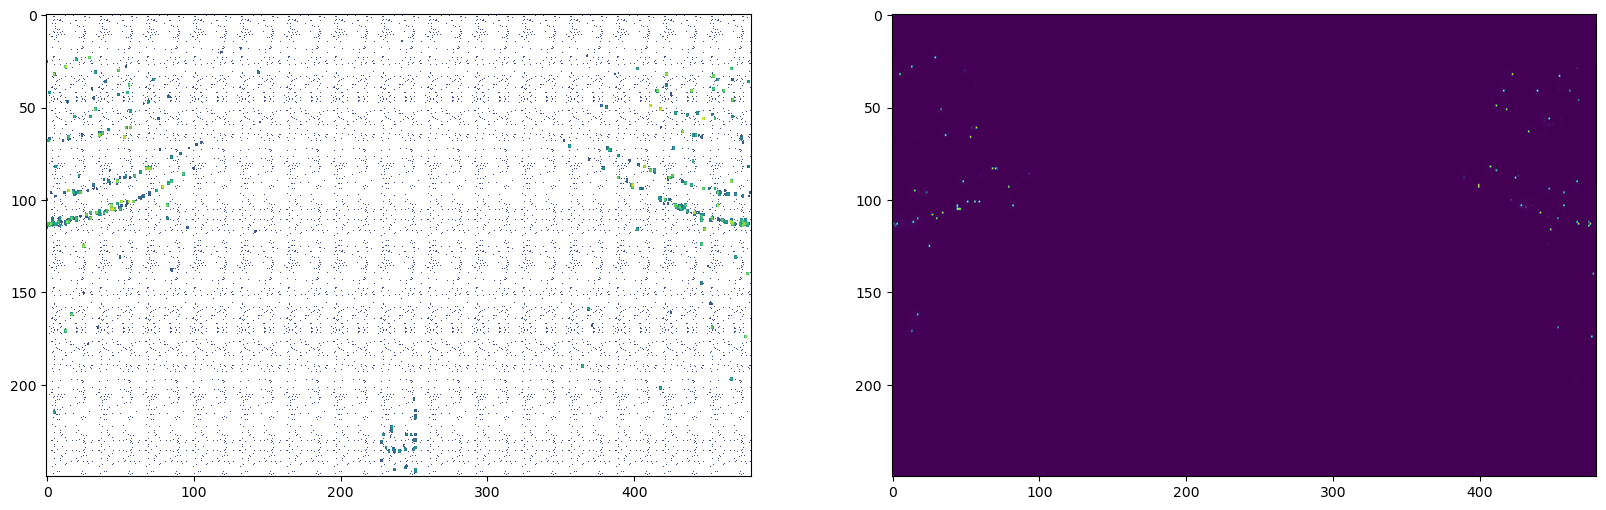

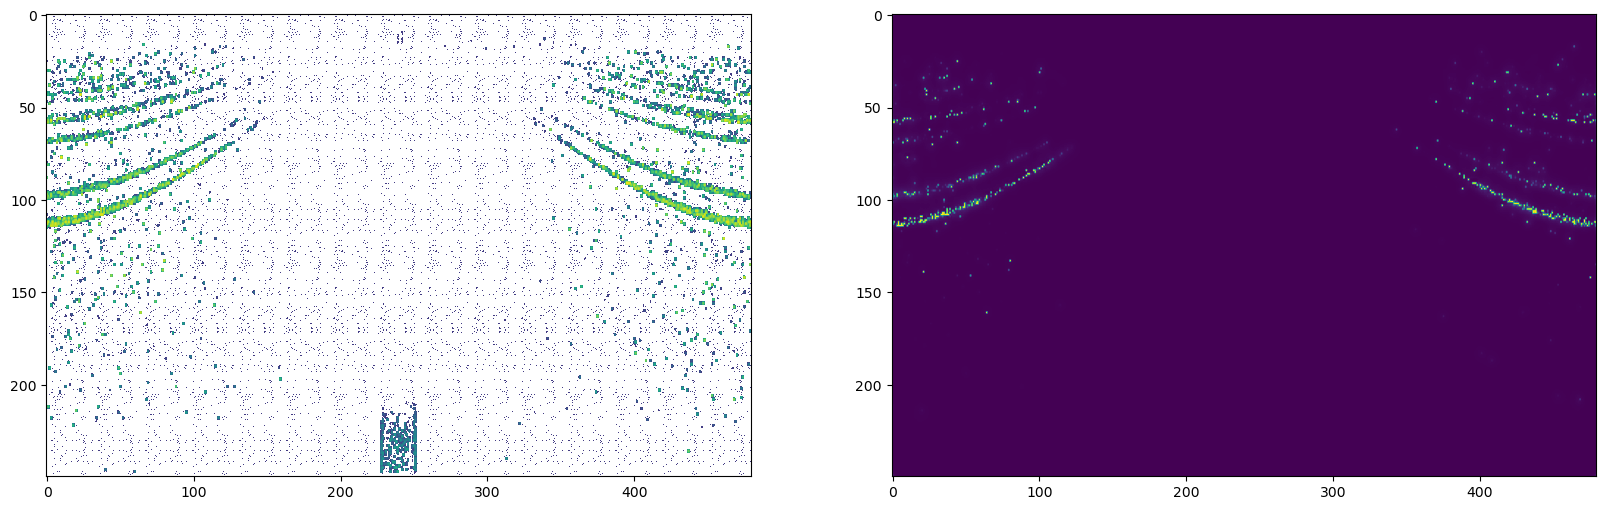

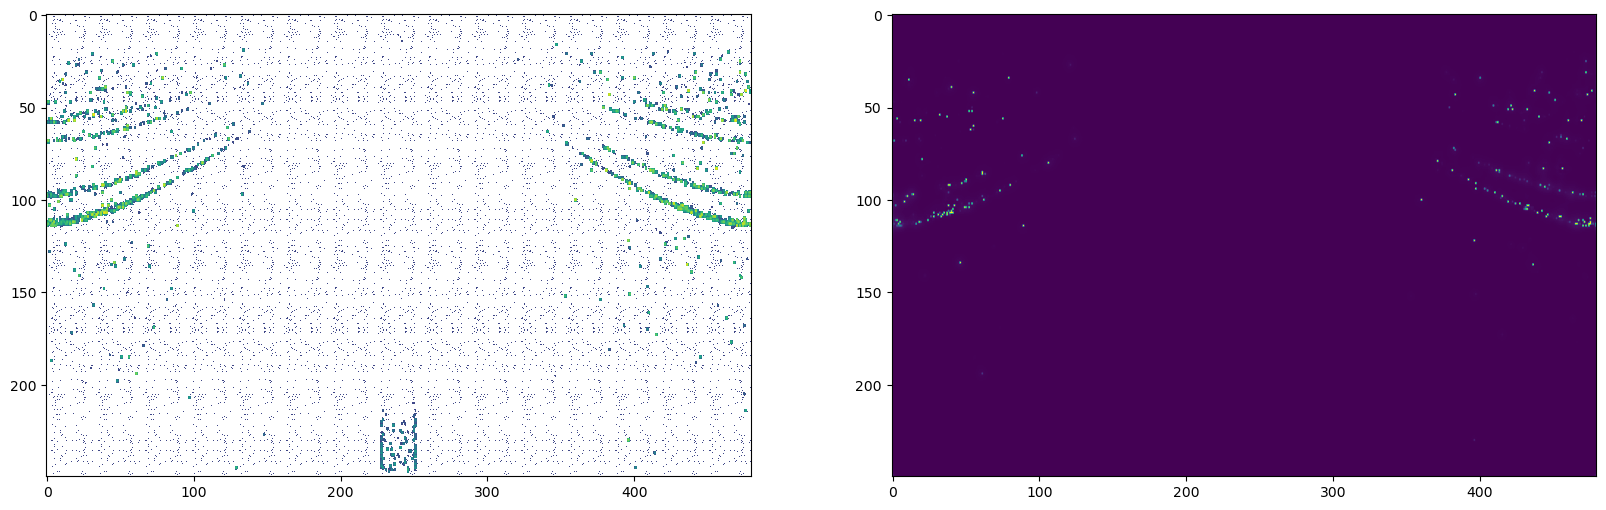

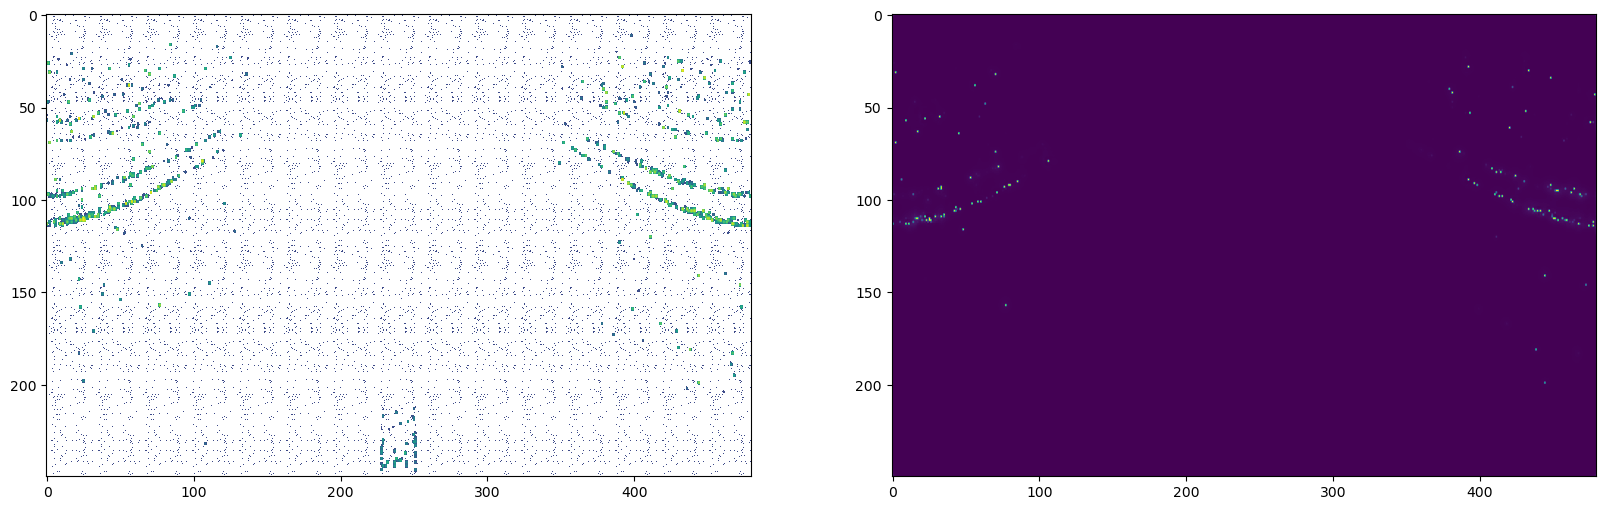

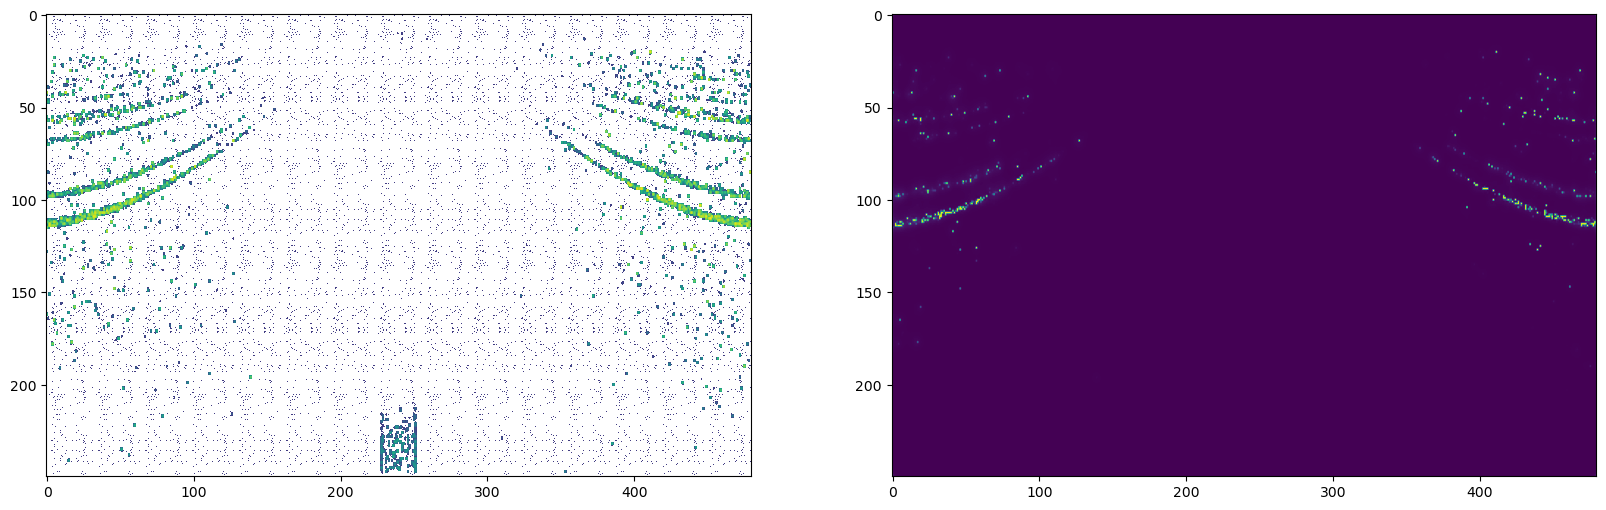

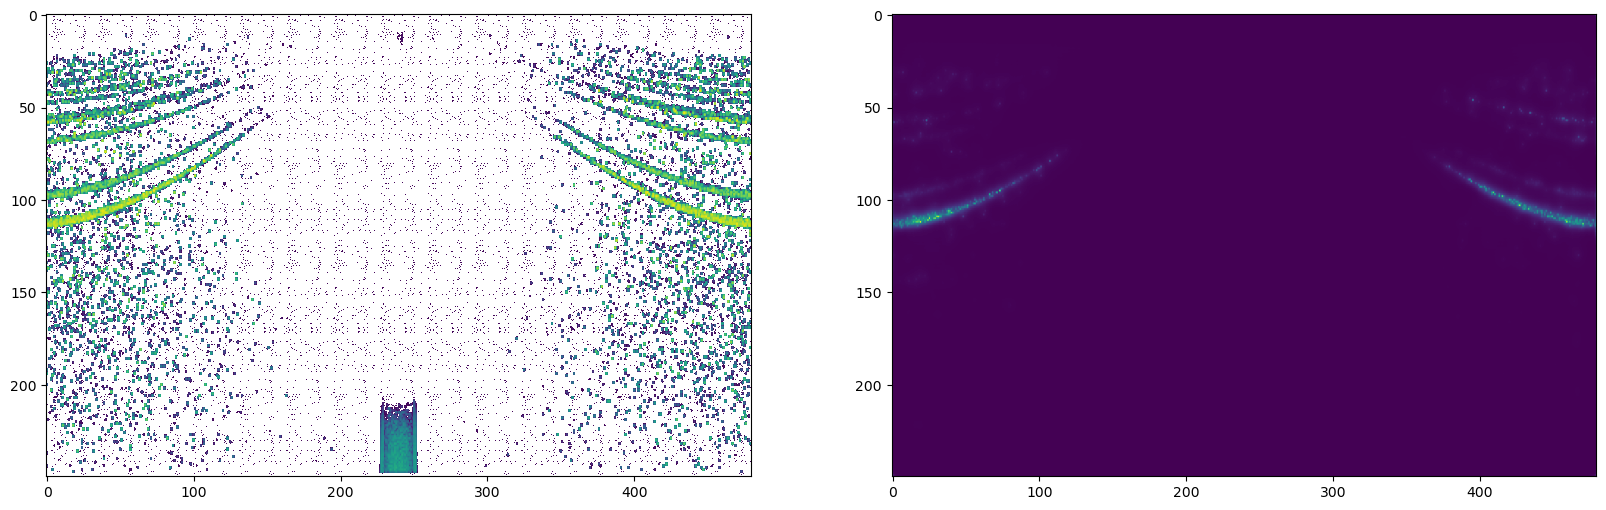

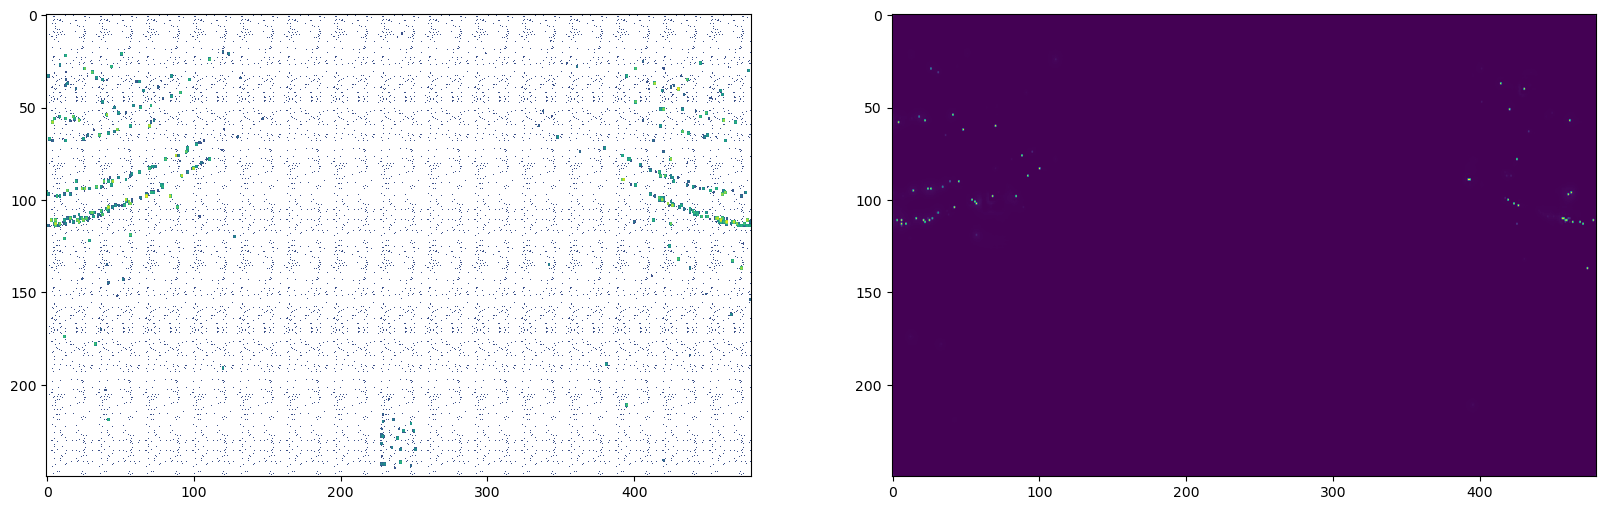

In [52]:
for i in range(len(diffs)):
    
    # Создаем фигуру и оси
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Первый график
    ax1.imshow(diffs[i][0][0], cmap='viridis', aspect='auto', norm='log')

    # Первый график
    ax2.imshow(outs[i][0][0], cmap='viridis', aspect='auto')

    plt.show()

In [31]:
import numpy as np


# Количество классов
num_classes = len(cristals)

# Углы для каждого класса (от 0 до 2*pi)
angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()

# Замкнем круг, добавив начальное значение в конец
class_accuracies += class_accuracies[:1]
angles += angles[:1]

# Построение графика
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, class_accuracies, linewidth=2, linestyle='solid')

# Заполнение области внутри графика
ax.fill(angles, class_accuracies, color='skyblue', alpha=0.4)

# Настройки осей
ax.set_yticks(np.arange(0.1, 1.1, step=0.2))  # Настройки сетки радиусов
ax.set_xticks(angles[:-1])  # Устанавливаем углы на оси X (углы)
ax.set_xticklabels(cristals)  # Устанавливаем названия классов

# Заголовок
plt.title('ResNet 18 : Accuracy distribution across elements', size=20, color='navy', y=1.1)

plt.show()

RuntimeError: unsupported operation: some elements of the input tensor and the written-to tensor refer to a single memory location. Please clone() the tensor before performing the operation.

In [35]:
# Инициализируем счетчики для TP, FP и FN для каждого класса
true_positives = torch.zeros(num_classes)
false_positives = torch.zeros(num_classes)
false_negatives = torch.zeros(num_classes)
total_predictions = torch.zeros(num_classes)
total_predictions = total_predictions.to(device)

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)  # Получаем логиты от модели
        _, predicted = torch.max(outputs, 1)  # Получаем предсказанные классы

        for i in range(num_classes):
            class_mask = (targets == i)  # Маска для всех примеров класса i
            correct_mask = (predicted == targets)  # Маска для правильно классифицированных примеров
            predicted_mask = (predicted == i)  # Маска для всех примеров, предсказанных как класс i

            # True Positives: правильно классифицированные примеры данного класса
            true_positives[i] += (predicted[class_mask] == targets[class_mask]).sum().item()

            # False Positives: примеры других классов, классифицированные как данный класс
            false_positives[i] += (predicted_mask & ~class_mask).sum().item()

            # False Negatives: примеры данного класса, ошибочно классифицированные как другой класс
            false_negatives[i] += (class_mask & ~correct_mask).sum().item()

        total_predictions += (targets == predicted).sum(dim=0).float()

#for i in range(len(true_positives)):
#    true_positives[i] = true_positives[i].to('cpu')
#    false_positives[i] = false_positives[i].to('cpu')
# Вычисляем Precision и Recall для каждого класса
precisions = true_positives / (true_positives + false_positives + 1e-8)
recalls = true_positives / (true_positives + false_negatives + 1e-8)

# Выводим результаты
for i in range(num_classes):
    print(f'Класс {cristals[i]}: Точность {class_accuracies[i]:.2f}')
    print(f'Класс {cristals[i]}: Precision {precisions[i]:.2f}, Recall {recalls[i]:.2f}')

Класс "Al.laz": Точность 1.00
Класс "Al.laz": Precision 0.86, Recall 0.43
Класс "Al2O3_sapphire.laz": Точность 1.00
Класс "Al2O3_sapphire.laz": Precision 1.00, Recall 0.11
Класс "Ba.laz": Точность 1.00
Класс "Ba.laz": Precision 0.00, Recall 0.00
Класс "Be.laz": Точность 1.00
Класс "Be.laz": Precision 0.62, Recall 0.56
Класс "BeO.laz": Точность 1.00
Класс "BeO.laz": Precision 0.00, Recall 0.00
Класс "C_diamond.laz": Точность 1.00
Класс "C_diamond.laz": Precision 0.75, Recall 0.67
Класс "C_graphite.laz": Точность 1.00
Класс "C_graphite.laz": Precision 1.00, Recall 0.44
Класс "Cr.laz": Точность 1.00
Класс "Cr.laz": Precision 0.00, Recall 0.00
Класс "Cs.laz": Точность 1.00
Класс "Cs.laz": Precision 0.00, Recall 0.00
Класс "Cu.laz": Точность 1.00
Класс "Cu.laz": Precision 0.29, Recall 0.18
Класс "Cu2MnAl.laz": Точность 1.00
Класс "Cu2MnAl.laz": Precision 0.20, Recall 0.33
Класс "Fe.laz": Точность 1.00
Класс "Fe.laz": Precision 0.12, Recall 0.06
Класс "Ga.laz": Точность 1.00
Класс "Ga.laz": 

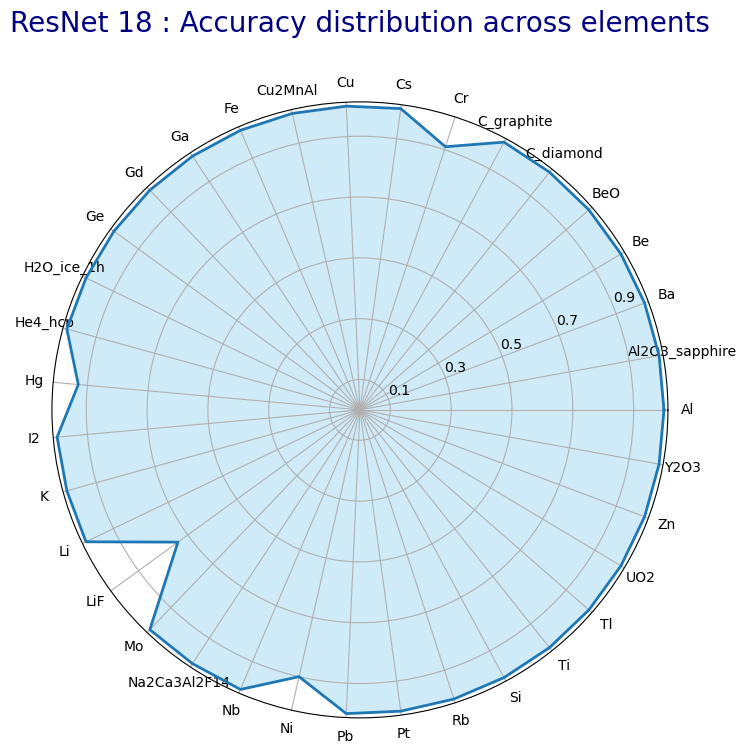

In [25]:
import numpy as np


# Количество классов
num_classes = len(classes_rn)

# Углы для каждого класса (от 0 до 2*pi)
angles = np.linspace(0, 2 * np.pi, num_classes, endpoint=False).tolist()

# Замкнем круг, добавив начальное значение в конец
accurcay_rn += accurcay_rn[:1]
angles += angles[:1]

# Построение графика
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, accurcay_rn, linewidth=2, linestyle='solid')

# Заполнение области внутри графика
ax.fill(angles, accurcay_rn, color='skyblue', alpha=0.4)

# Настройки осей
ax.set_yticks(np.arange(0.1, 1.1, step=0.2))  # Настройки сетки радиусов
ax.set_xticks(angles[:-1])  # Устанавливаем углы на оси X (углы)
ax.set_xticklabels(classes_rn)  # Устанавливаем названия классов

# Заголовок
plt.title('ResNet 18 : Accuracy distribution across elements', size=20, color='navy', y=1.1)

plt.show()

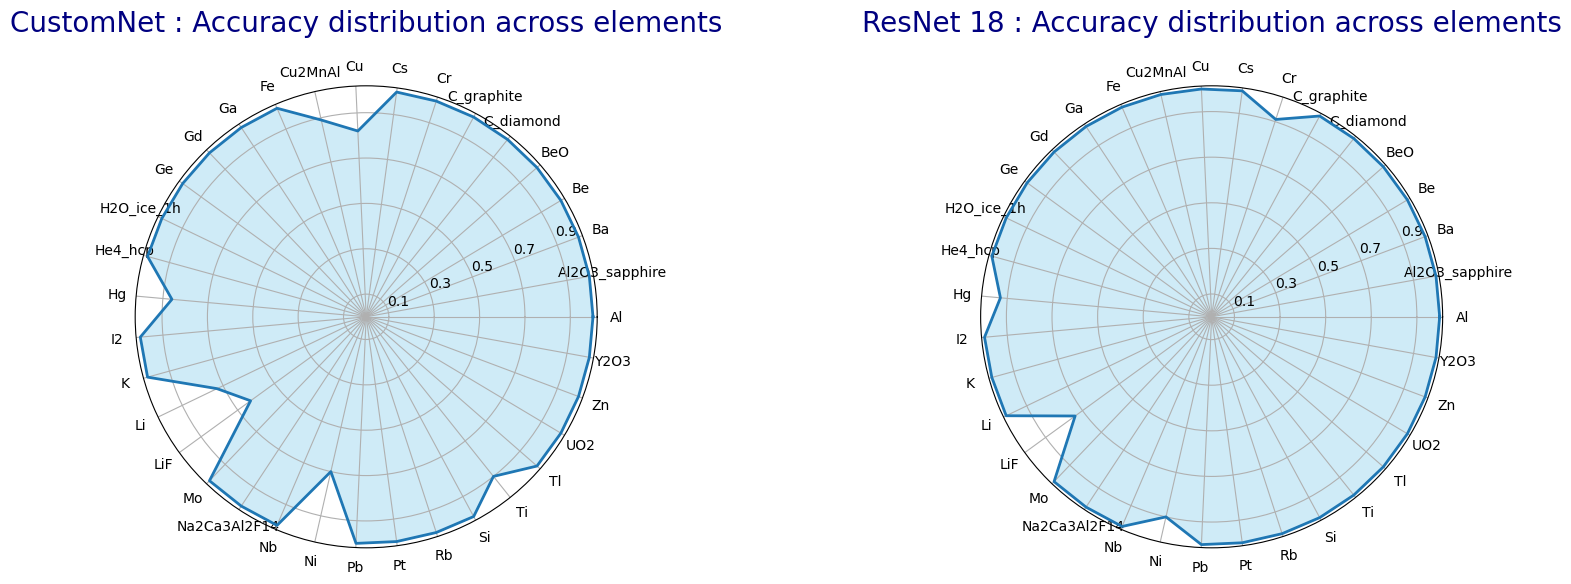

In [100]:
# Создаем фигуру и оси
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw=dict(polar=True))

# Первый график
ax1.plot(angles, accurcay_co, linewidth=2, linestyle='solid')

# Заполнение области внутри графика
ax1.fill(angles, accurcay_co, color='skyblue', alpha=0.4)

# Настройки осей
ax1.set_yticks(np.arange(0.1, 1.1, step=0.2))  # Настройки сетки радиусов
ax1.set_xticks(angles[:-1])  # Устанавливаем углы на оси X (углы)
ax1.set_xticklabels(classes_co)  # Устанавливаем названия классов
ax1.set_title('CustomNet : Accuracy distribution across elements', size=20, color='navy', y=1.1)

#Второй график
ax2.plot(angles, accurcay_rn, linewidth=2, linestyle='solid')

# Заполнение области внутри графика
ax2.fill(angles, accurcay_rn, color='skyblue', alpha=0.4)

# Настройки осей
ax2.set_yticks(np.arange(0.1, 1.1, step=0.2))  # Настройки сетки радиусов
ax2.set_xticks(angles[:-1])  # Устанавливаем углы на оси X (углы)
ax2.set_xticklabels(classes_rn)  # Устанавливаем названия классов
ax2.set_title('ResNet 18 : Accuracy distribution across elements', size=20, color='navy', y=1.1)

plt.show()